In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq,
    Poly,
    diff,
    nsolve,
    O,
    I,
    sqrt,
    pi,
    Add
)
from sympy.core.numbers import NegativeOne, One, Zero
import numpy as np
import pandas as pd
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
#from pymad_hzb.PlotTools import new_plot_elems_madx
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSQuad6D,
    HamSext6D
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick, fixedpoints2D
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot

from acchamiltoniansandmatrices.Factorization.Factorization import truncate
from acchamiltoniansandmatrices.Tracking.LieMapTracking import AssignHam, RingHam
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList

In [5]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0*gamma0,beta0],[oo,1]))
series_rep = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep = list(zip([x,y],[eps*x,eps*y]))
thin_rep = list(zip([px,py,delta],[0,0,0]))
xpx_rep = list(zip([y,py,delta],[0,0,0]))

In [6]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
    betagamma_rep = list(
        zip(
            [
                beta0*gamma0,
                beta0
            ],
            [
                oo,
                1
            ]
        )
    )
    series_rep = list(
        zip(
            [
                px,
                py,
                delta
            ],
            [
                eps*px,
                eps*py,
                eps*delta
            ]
        )
    )
    coord_rep = list(zip([x,y],[eps*x,eps*y]))

    thin_rep = list(zip([px,py,delta],[0,0,0]))
    if element == 1:
        # drift hamiltonian
        H = HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
#         H = drift(order, length)
        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * Rational(1,2) * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() * Rational(1,2) * HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() * Rational(1,2) * HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = sext(order, length, strength, flag)
#     elif H == 35:
#         H = skew_sext(order, length, strength)
    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H


def truncate(LieHam,degree): #cutoff Hamiltonian at specified degree
    _epstemp = symbols('e')
    fct = LieHam.ham
    
    for i in LieHam.indep_coords:
        fct = fct.subs(i,i*_epstemp)
        
    for i in LieHam.indep_mom:
        fct = fct.subs(i,i*_epstemp)
    
    fct = fct.expand()
    fct = fct + O(_epstemp**degree)
    fct = fct.removeO().subs(_epstemp,1)
    
    return fct


def RingHam(beamline,BCH_order,poly_cutoff, doit=False): #combine beamline with BCH into one map
    poly_cutoff = poly_cutoff + 1
    for i,element in enumerate(beamline):
        if i == 0:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H_int = LieOperator(H0,[x,y,z],[px,py,delta])
        else:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H0 = LieOperator(H0,[x,y,z],[px,py,delta])
            
            H_int = H_int.BCH(H0,BCH_order)
            
        
            H_int = H_int.doit()
    
    temp_H = truncate(H_int,poly_cutoff) #cutoff Hamiltonian at speciefied polynomial degree
    
    H = LieOperator(temp_H,[x,y,z],[px,py,delta])
    
    
    return H

In [7]:
# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta,
        dld
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
        1.5e-3,
        1
    ]
)
          )


In [122]:
# we start with BCH order 2 and exponential expansion order 4

thin = 1
bchorder = 3
polyorder = 4

eldict = {
    'drift' : 1,
    'quad'  : 2,
    'squad' : 25,
    'sext'  : 3
}

beamline = [
    [eldict['quad'] , 2, LQF, KQF, thin],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 2, LQD, KQD, thin],
    [eldict['drift'], 4, LD + dld,   Zero(), 0   ],
    [eldict['quad'] , 2, LQF, KQF, thin],
]

Hring = RingHam(beamline,bchorder,polyorder).ham

KeyboardInterrupt: 

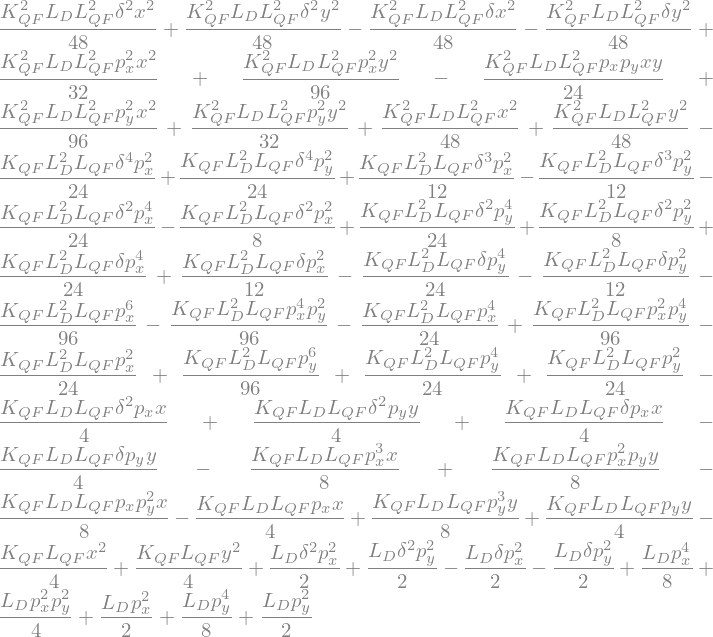

In [126]:
bchorder = 3
element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H_int = LieOperator(H0,[x,y,z],[px,py,delta])
H_int.doit()

element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int = H_int.BCH(H0,bchorder)
H_int.doit()

# element = beamline[2]
# H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
# H0 = LieOperator(H0,[x,y,z],[px,py,delta])
# H_int = H_int.BCH(H0,bchorder).doit()

# element = beamline[3]
# H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
# H0 = LieOperator(H0,[x,y,z],[px,py,delta])
# H_int = H_int.BCH(H0,bchorder).doit()

# element = beamline[4]
# H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
# H0 = LieOperator(H0,[x,y,z],[px,py,delta])
# H_int = H_int.BCH(H0,bchorder).doit()

H_int.ham.doit().expand()

In [93]:
Hring = Hring.expand()

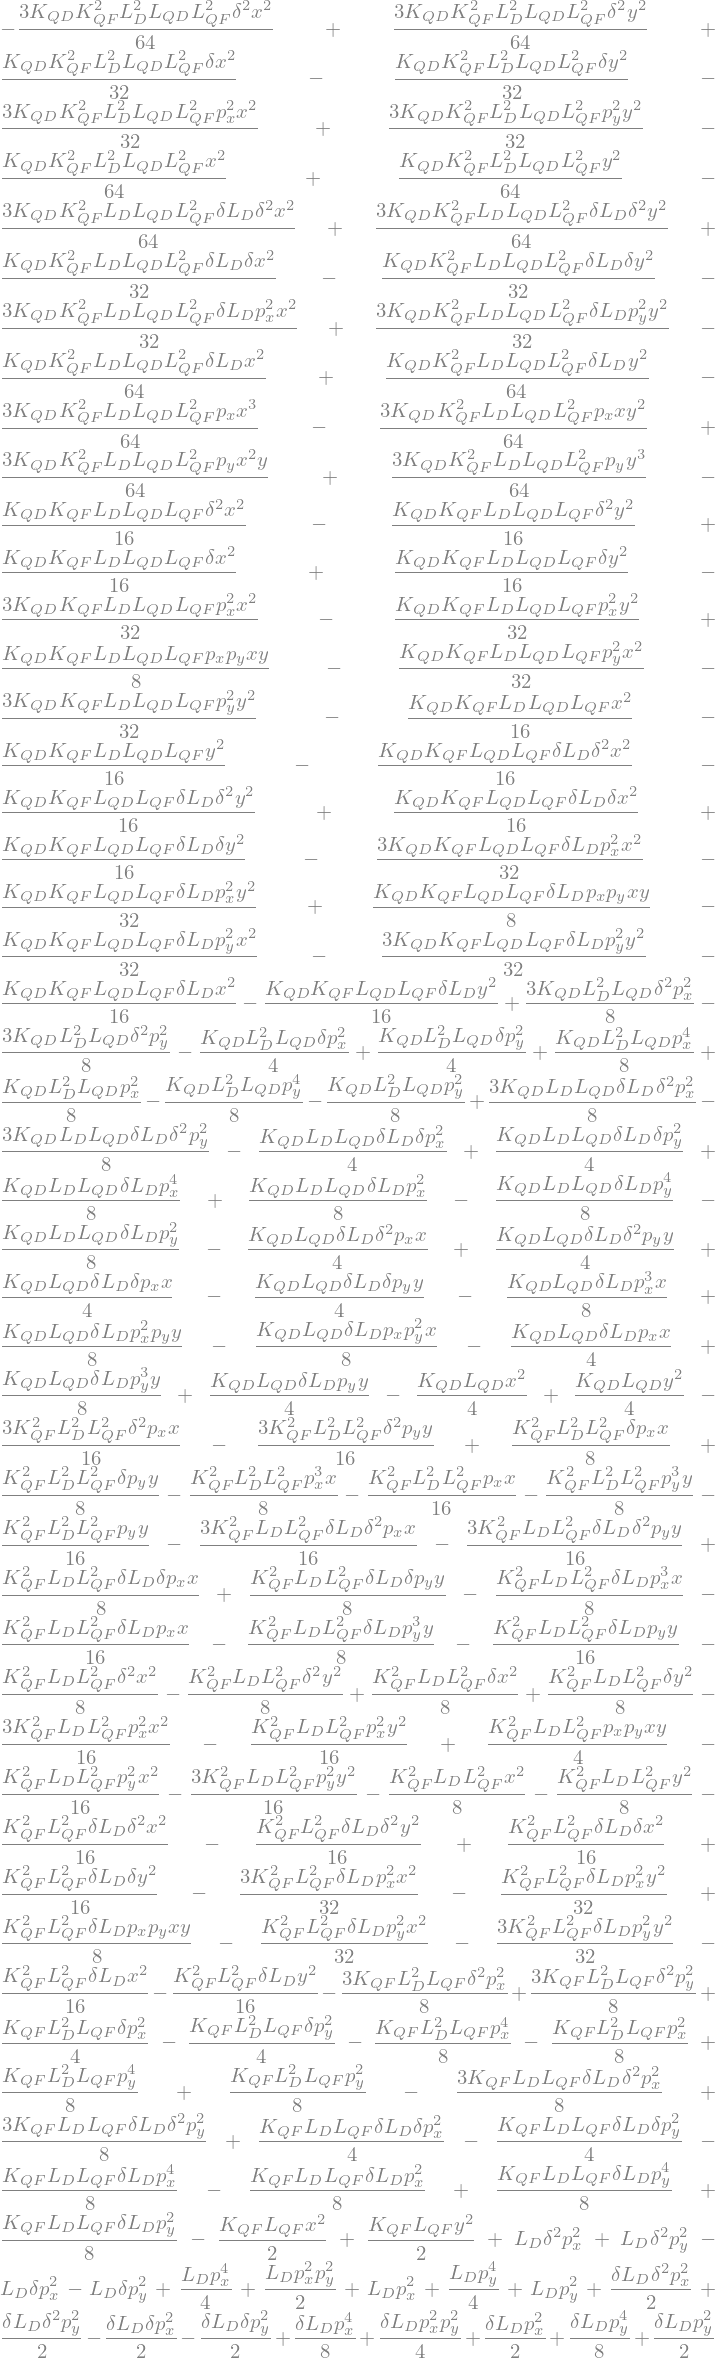

In [87]:
Hring

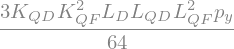

In [105]:
Hring.coeff(x**2*y)

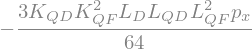

In [106]:
Hring.coeff(x*y**2)

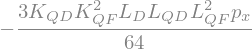

In [107]:
Hring.coeff(x**3)

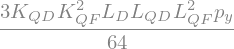

In [108]:
Hring.coeff(y**3)

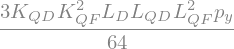

In [121]:
Hring.coeff(y**3)

In [118]:
t1 = Hring.coeff(x**3)*x**3
t1 = t1.subs(px,.5).subs(rep)
t2 = Hring.coeff(y**2*x)*y**2*x
t2 = t2.subs(px,.5).subs(rep)
t1, t2

<IPython.core.display.Javascript object>


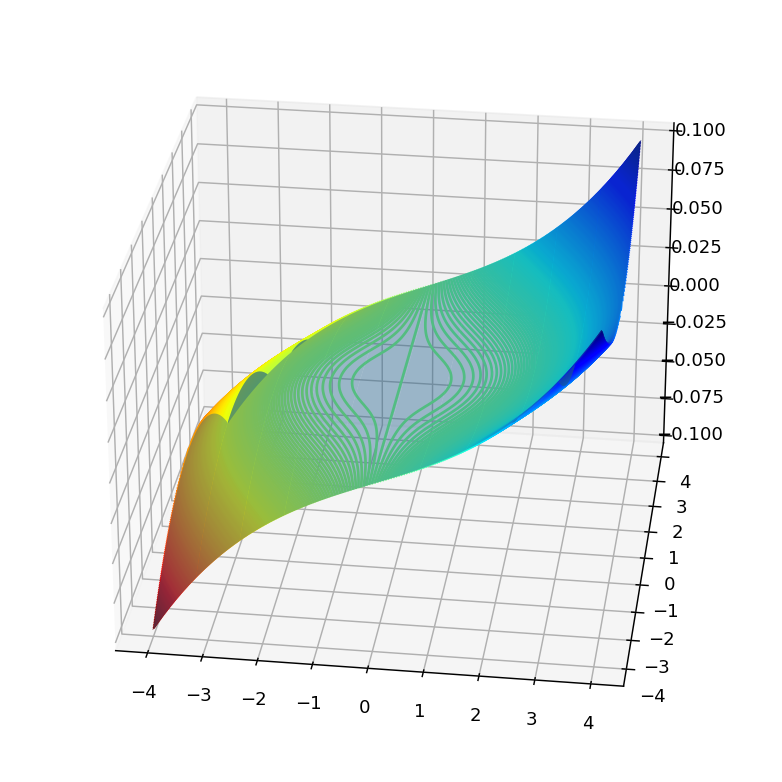

In [119]:

func = lambdify((x,y),t1+t2,'numpy')
multi_countour_plot(
    [func], 
    titlelist=["$1^e$ order","$2^e$ order","$3^e$ order","$4^e$ order"],
    xlabels=[r"$x$"]*4,
    ylabels=[r"$p_x$"]*4,
    xrange=4,
    prange=4,
    nlevels=400,
    size = (6,6),
    d3=True
)

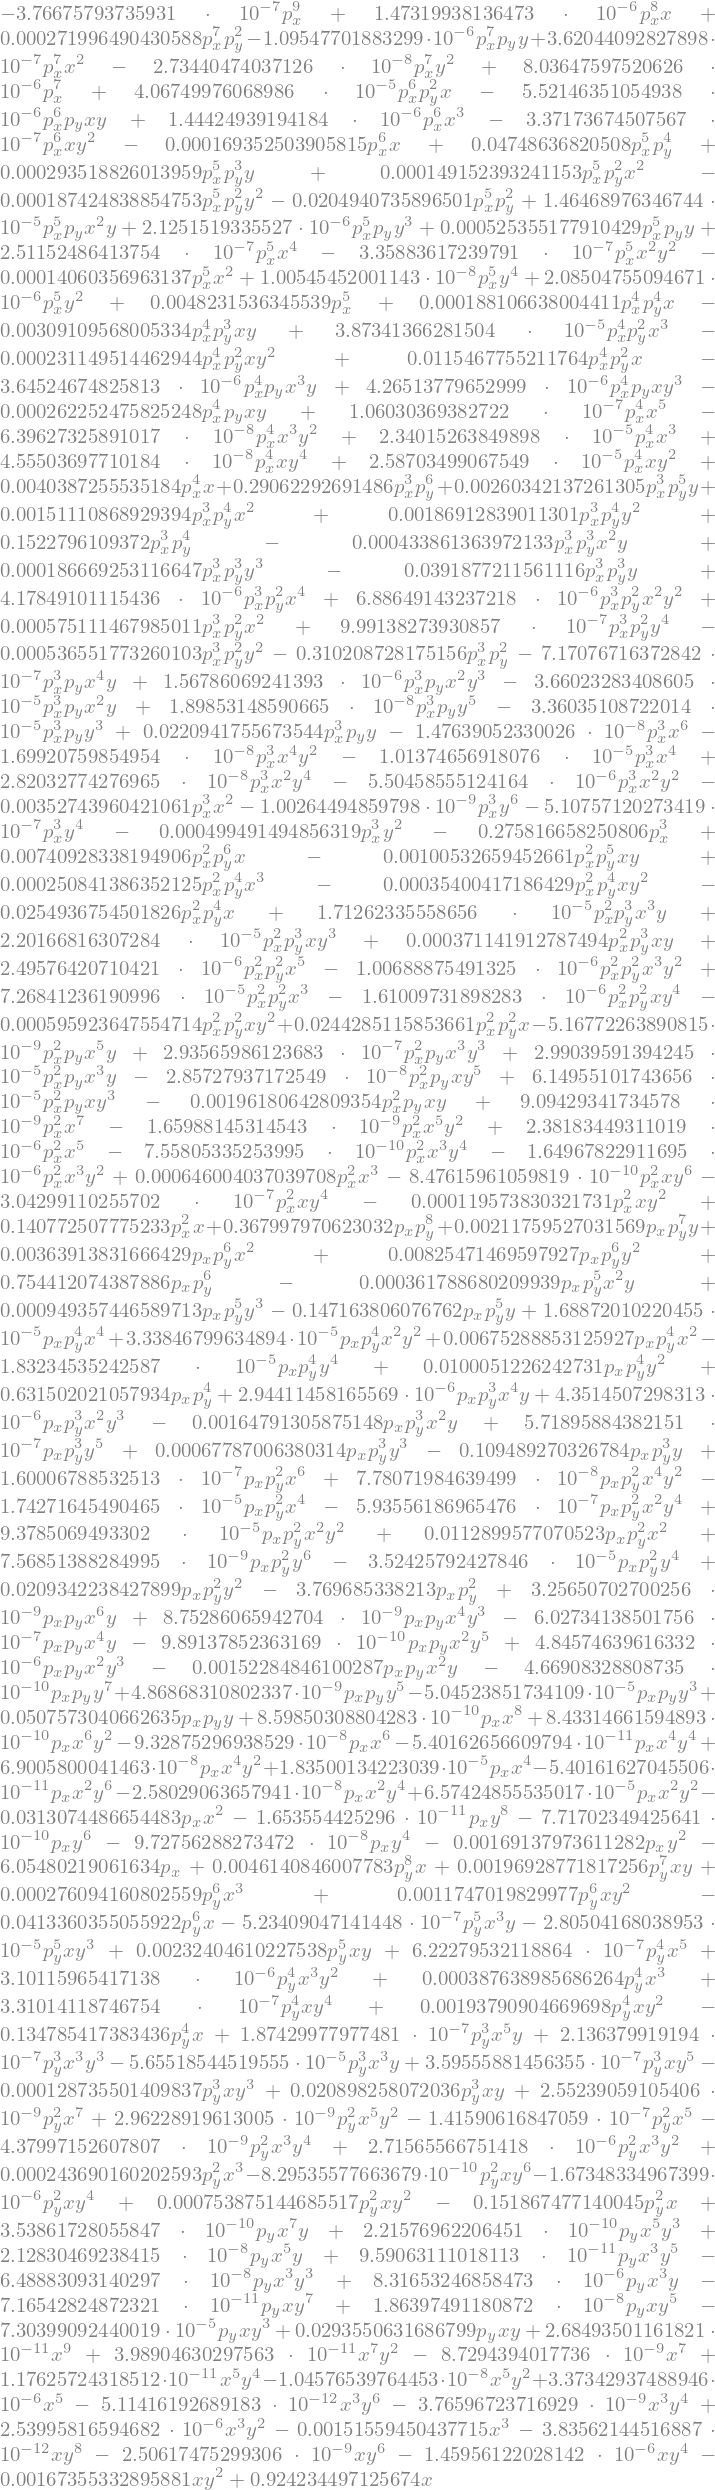

In [88]:
LieOperator(Hring.subs(rep),[x,y],[px,py]).LieMap(x ,trackorder).ham.doit().expand()

In [94]:
trackorder = 4
funcx  = LieOperator(Hring.subs(rep),[x,y],[px,py]).LieMap(x ,trackorder).ham.doit().subs(delta,0)
funcpx = LieOperator(Hring.subs(rep),[x,y],[px,py]).LieMap(px,trackorder).ham.doit().subs(delta,0)
funcy  = LieOperator(Hring.subs(rep),[x,y],[px,py]).LieMap(y ,trackorder).ham.doit().subs(delta,0)
funcpy = LieOperator(Hring.subs(rep),[x,y],[px,py]).LieMap(py,trackorder).ham.doit().subs(delta,0)

x_prop  = lambdify((x,px,y,py),funcx , 'numpy')
px_prop = lambdify((x,px,y,py),funcpx, 'numpy')
y_prop  = lambdify((x,px,y,py),funcy , 'numpy')
py_prop = lambdify((x,px,y,py),funcpx, 'numpy')

def propagate(vec4D):
    xn  = x_prop(*vec4D)
    pxn = px_prop(*vec4D)
    yn  = y_prop(*vec4D)
    pyn = py_prop(*vec4D)
    return np.array([xn,pxn,yn,pyn])

In [95]:
from itertools import product

x0    = [0, 1,1.95,1.975,1.9875,2,2.2]#,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]
px0   = [0.05]
r0arr = [np.array(t + (0,0) )for t in list(product(x0,px0))]

turns = 1000
res   = []

for r0 in r0arr:
    locres =  np.array(
        list(nestList(propagate,r0,turns))
    )
    res.append(locres)

<lambdifygenerated-45>:2: RuntimeWarning: overflow encountered in double_scalars
  return (1.54219824969643*p_x**5 + 0.107947409026837*p_x**4*x + 1.02813216646429*p_x**3*p_y**2 - 0.0287859757404898*p_x**3*p_y*y - 0.0360472237280404*p_x**3*x**2 - 0.00240314824853603*p_x**3*y**2 + 0.0258691260478626*p_x**3 + 0.0431789636107346*p_x**2*p_y**2*x + 0.0144188894912162*p_x**2*p_y*x*y + 0.0472322192719466*p_x**2*x - 0.514066083232144*p_x*p_y**4 + 0.0287859757404898*p_x*p_y**3*y - 0.00720944474560808*p_x*p_y**2*x**2 + 0.00720944474560808*p_x*p_y**2*y**2 - 4.0805*p_x*p_y**2 + 0.0834833*p_x*p_y*y - 0.0338835930402566*p_x*x**2 - 0.00169633528043175*p_x*y**2 - 6.09866745640534*p_x - 0.00719649393512244*p_y**4*x - 0.00480629649707206*p_y**3*x*y - 0.04174165*p_y**2*x + 0.0033926705608635*p_y*x*y - 0.00157394274546623*x**3 - 0.00157394274546623*x*y**2 + 0.94534154903702*x - 1/6*(-(-0.0720944474560808*p_x**3 - 0.0144188894912162*p_x*p_y**2 - 0.0677671860805133*p_x - 0.00944365647279741*x)*(-1.5421982496

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


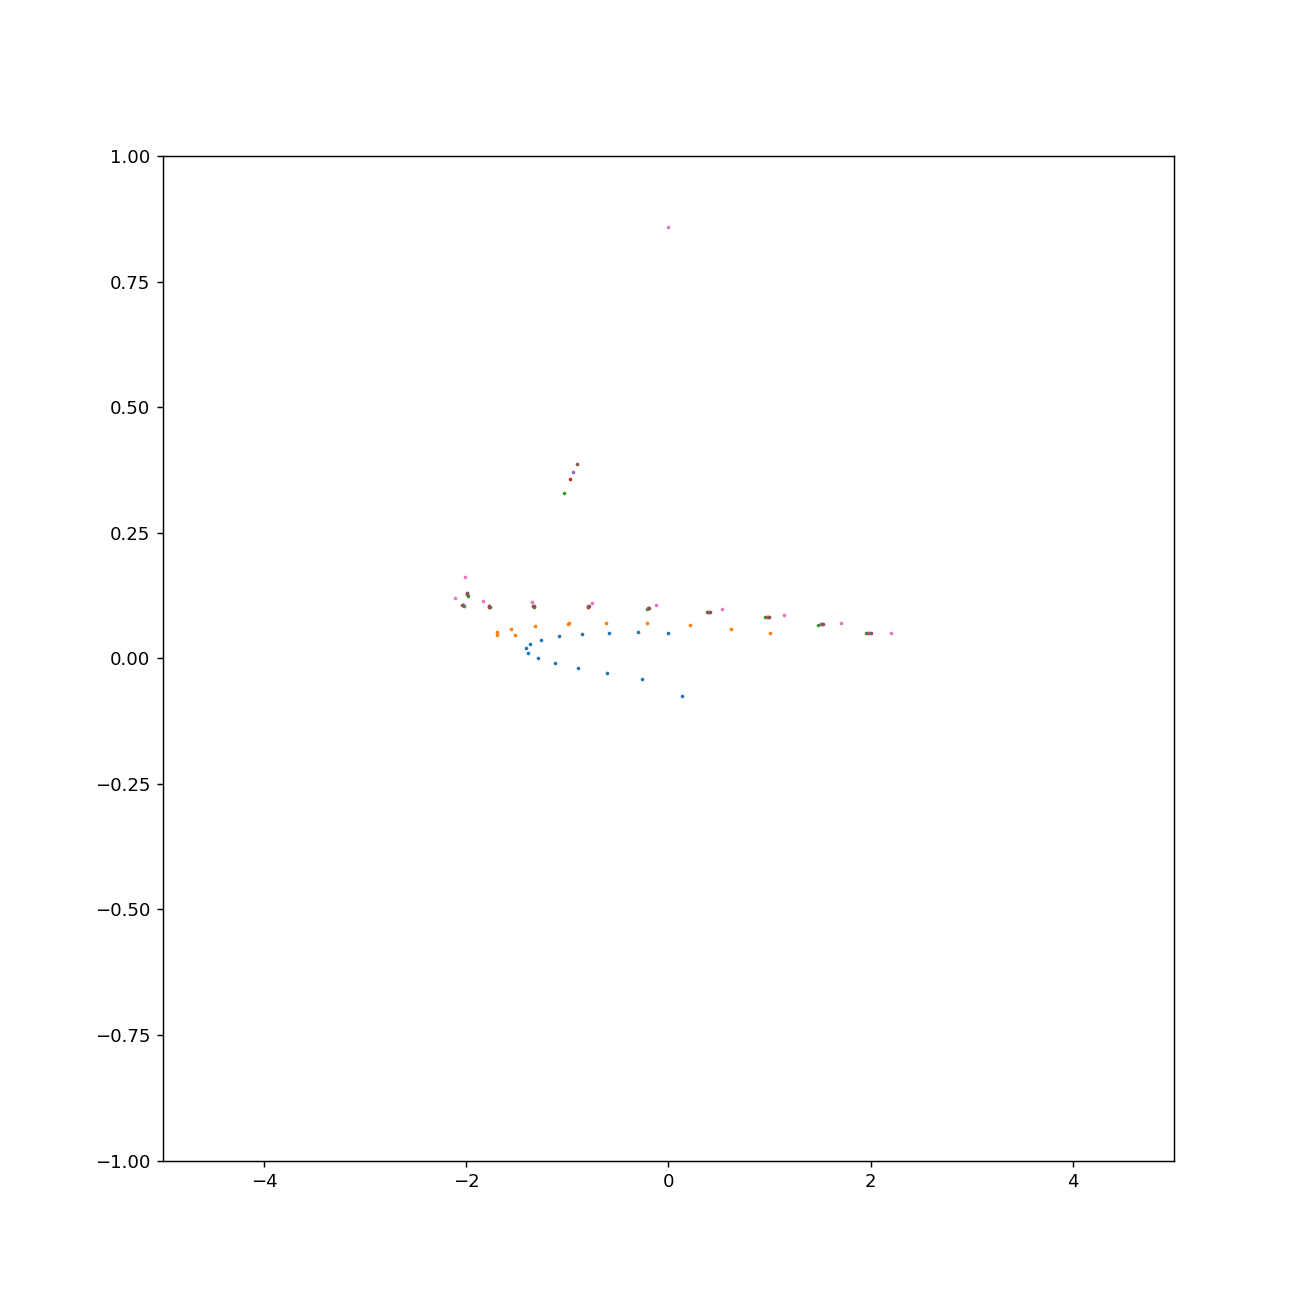

In [91]:
plt.figure(figsize=(10,10))
for trackres in res:
    XXX = trackres[:,0]
    PXX = trackres[:,1]
    plt.scatter(XXX,PXX,s=1)
    
plt.xlim(-5,5)
plt.ylim(-1,1)

In [137]:
PoissonBracket(x**2,PoissonBracket(x**2,PoissonBracket(x**2,PoissonBracket(x**2,px**4))), coords=[x], mom=[px]).doit()